## Loading

In [7]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Python version

In [8]:
import sys, site
print("Python:", sys.executable)
print("User site:", site.getusersitepackages())
print("Site-packages:", site.getsitepackages() if hasattr(site, "getsitepackages") else "n/a")

Python: /home/nicolas/.pyenv/versions/venv_python_3.11.5-GCCcore-13.2.0/bin/python
User site: /home/nicolas/.local/lib/python3.11/site-packages
Site-packages: ['/home/nicolas/.pyenv/versions/venv_python_3.11.5-GCCcore-13.2.0/lib/python3.11/site-packages']


## Librairies

In [9]:
import pickle
from tqdm import tqdm
from pathlib import Path

import numpy as np
import polars as pl
import pyarrow.parquet as pq

from matplotlib import pyplot as plt
from tqdm import tqdm

## Getting datas

In [10]:
def getting_main_file_and_verification(
    df: pl.DataFrame,
    nt: int = 10000,
    tmax: int = 100,
    dt: int = 1,
    alphao: float = 0.0,
    alphaf: float = 1.0,
    beta: float = 0.0,
    Lmin: int = 0,
    Lmax: int = 50_000,
    origin: int = 10_000,
    bps: int = 1
) -> pl.DataFrame:
    """
    Filters a Polars DataFrame based on specific criteria.

    Args:
        df (pl.DataFrame): The input DataFrame containing the dataset.
        nt (int, default=1000): Number of time steps in the simulation.
        tmax (int, default=100000): Maximum simulation time.
        dt (int): Time step interval.
        alphao (float, default=0.5): Initial alpha value.
        alphaf (float, default=0.5): Final alpha value.
        beta (float, default=1.0): Beta value used in the simulation.
        Lmin (int, default=0): Minimum linker length.
        Lmax (int, default=500): Maximum linker length.
        origin (int, default=0): Origin value used in the setup.
        bps (int, default=10): Base pairs per step.

    Returns:
        pl.DataFrame: The filtered DataFrame based on the given parameters.
    """

    selected_columns = {
        "alpha_choice", "s", "l", "bpmin", 
        "mu", "theta", 
        "nt", "tmax", "dt", "times", 
        "alphao", "alphaf", "beta",
        "Lmin", "Lmax", "origin", "bps",
        
        "v_mean", "v_med", 
        "vf", "Cf", "wf", "vf_std", "Cf_std", "wf_std", 
        "vi_mean", "vi_med", "vi_mp",
    }

    # Select only the required columns
    filtered_columns = [col for col in df.columns if col in selected_columns]
    filtered_df = df.select(filtered_columns)

    # Verify that all rows have 's' equal to 150
    if (filtered_df["s"] == 150).all():
        print("All rows have s = 150.")
    else:
        print("Some rows do not have s = 150.")
        print(filtered_df.filter(pl.col("s") != 150))

    # Apply filtering based on predefined conditions
    filtered_df = (
        filtered_df
        .filter(pl.col("nt") == nt)
        .filter(pl.col("tmax") == tmax)
        .filter(pl.col("dt") == dt)
        .filter(pl.col("alphao") == alphao)
        .filter(pl.col("alphaf") == alphaf)
        .filter(pl.col("beta") == beta)
        .filter(pl.col("Lmin") == Lmin)
        .filter(pl.col("Lmax") == Lmax)
        .filter(pl.col("origin") == origin)
        .filter(pl.col("bps") == bps)
    )

    return filtered_df


# Reading it for further manipulations
main_file_path = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "2025-01-01_PSMN" / "ncl_output.parquet"
data = pq.read_table(main_file_path)
df_polars = pl.DataFrame(data)

# Loading file + Filtering
df_pl_main = getting_main_file_and_verification(df_polars)
print('The df_polars containing the int and floats for all our simulations :\nTotal shape :',df_pl_main.shape, '\nQuick print and shape :', df_pl_main.head(5))

All rows have s = 150.
The df_polars containing the int and floats for all our simulations :
Total shape : (131300, 27) 
Quick print and shape : shape: (5, 27)
┌──────────────┬─────┬─────┬───────┬───┬────────┬───────────┬────────────┬───────┐
│ alpha_choice ┆ s   ┆ l   ┆ bpmin ┆ … ┆ wf_std ┆ vi_mean   ┆ vi_med     ┆ vi_mp │
│ ---          ┆ --- ┆ --- ┆ ---   ┆   ┆ ---    ┆ ---       ┆ ---        ┆ ---   │
│ str          ┆ i64 ┆ i64 ┆ i64   ┆   ┆ f64    ┆ f64       ┆ f64        ┆ f64   │
╞══════════════╪═════╪═════╪═══════╪═══╪════════╪═══════════╪════════════╪═══════╡
│ nt_random    ┆ 150 ┆ 10  ┆ 15    ┆ … ┆ 0.004  ┆ 42.932289 ┆ 0.000023   ┆ 0.5   │
│ nt_random    ┆ 150 ┆ 10  ┆ 15    ┆ … ┆ 0.005  ┆ 53.026867 ┆ 0.009536   ┆ 0.5   │
│ nt_random    ┆ 150 ┆ 10  ┆ 15    ┆ … ┆ 0.007  ┆ 53.843803 ┆ 0.001263   ┆ 0.5   │
│ nt_random    ┆ 150 ┆ 10  ┆ 15    ┆ … ┆ 0.007  ┆ 31.117475 ┆ 0.000045   ┆ 0.5   │
│ nt_random    ┆ 150 ┆ 10  ┆ 15    ┆ … ┆ 0.005  ┆ 23.223647 ┆ 3.2930e-15 ┆ 0.5   │
└─────────

## Heatmaps

Plotting heatmaps: 100%|██████████| 13/13 [00:00<00:00, 22.39it/s]


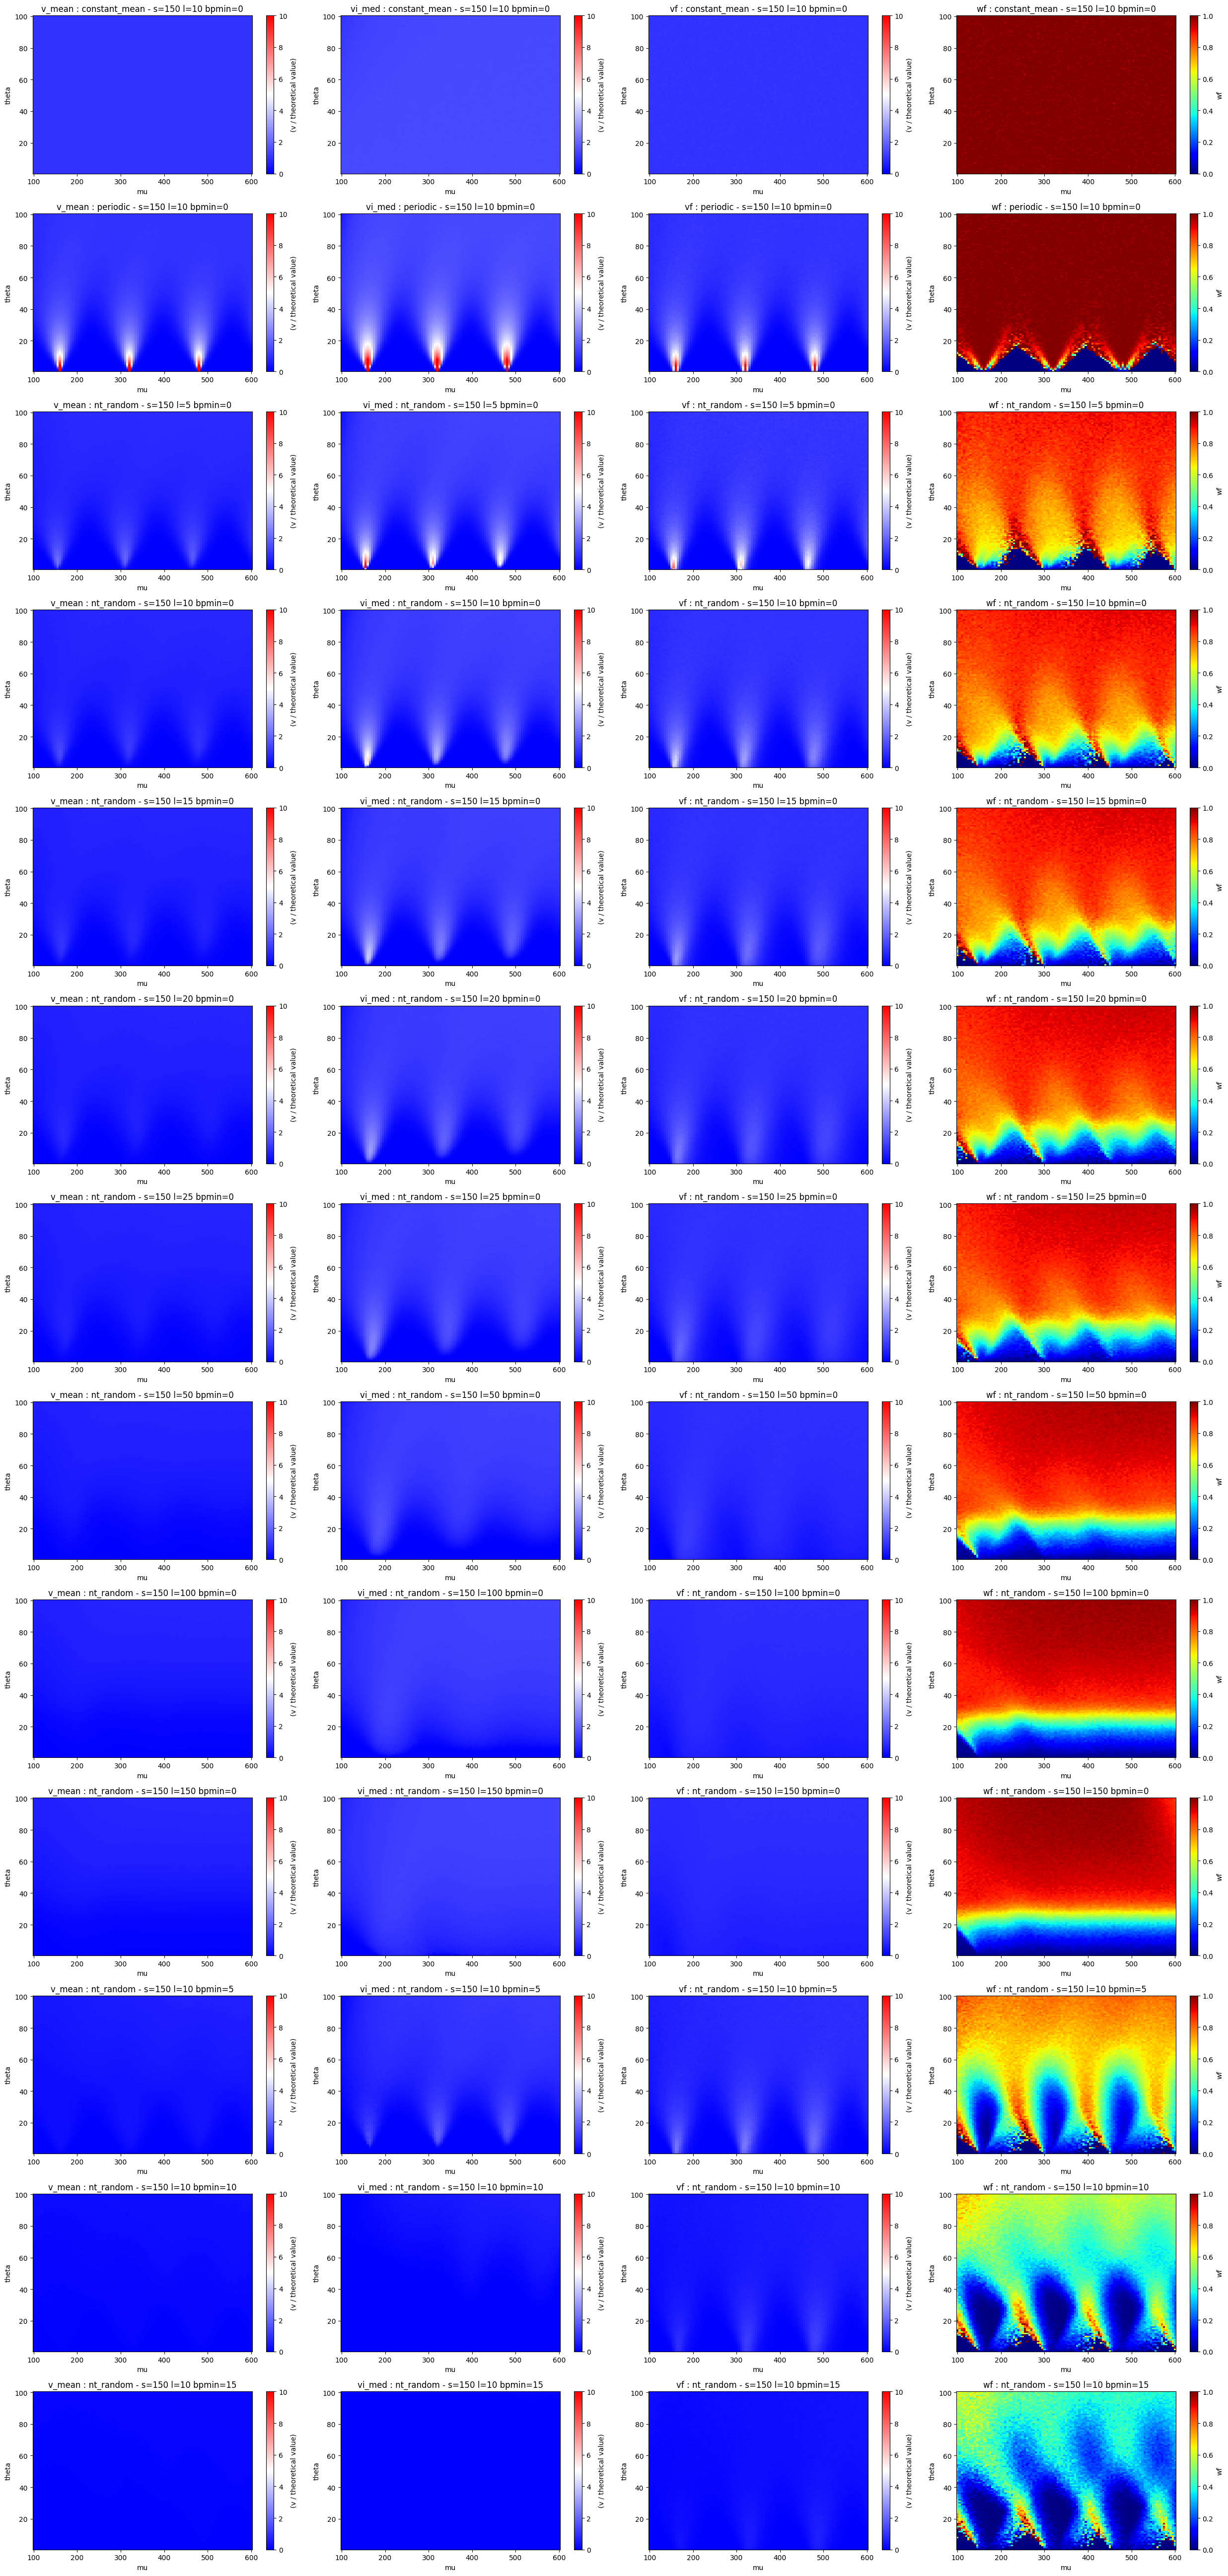

In [11]:
def ncl_plot_precomputed_heatmaps(speed_cols, root = Path.home() / "Documents" / "PhD" / "Workspace" / "nucleo" / "outputs" / "2025-01-01_PSMN", type_of_data="raw", plot_log2=False):
    """
    Plots heatmaps of either raw or log2-transformed values depending on the variable:
    - log2 + bwr for all except wf
    - linear + jet for wf

    Data are already normalized by the theoretical values of the constant_value scenario !

    """

    if plot_log2:
        title_bar_mini = "log₂ "
    else:
        title_bar_mini = ""

    if type_of_data not in ["raw", "norm_mu", "norm_th"]:
        raise ValueError ("No such type_of_data possible to plot.")

    if type_of_data == "raw":
        main_file_path = root / "hmp_nucleo_raw.pkl"
        title_bar = title_bar_mini + "v"
        if plot_log2:
            vmin, vmax = -2, 10
        else :
            vmin, vmax = 0, 50

    elif type_of_data == "norm_mu":
        main_file_path = root / "hmp_nucleo_nmu.pkl"
        title_bar = title_bar_mini + "(v / mean value)"
        if plot_log2:
            vmin, vmax = -1, 0.010
        else:
            vmin, vmax = 0, 0.50

    elif type_of_data == "norm_th":
        main_file_path = root / "hmp_nucleo_nth.pkl"
        title_bar = title_bar_mini + "(v / theoretical value)"
        if plot_log2:
            vmin, vmax = -2, 2
        else:
            vmin, vmax = 0, 10

    with open(main_file_path, "rb") as f:
        computed_data = pickle.load(f)

    n_combinations = len(computed_data)
    fig, axes = plt.subplots(nrows=n_combinations, ncols=len(speed_cols), figsize=(25, 4 * n_combinations))
    axes = np.atleast_2d(axes)

    for idx, (key, config_data) in enumerate(tqdm(computed_data.items(), total=n_combinations, desc="Plotting heatmaps")):
        mu_values = config_data["mu_values"]
        theta_values = config_data["theta_values"]
        config = config_data["config"]

        for col_idx, speed_col in enumerate(speed_cols):
            ax = axes[idx, col_idx]
            data = config_data[speed_col]

            if speed_col == "wf":
                cmap = 'jet'
                wmin = 0
                wmax = 1
                data_to_plot = data
                c = ax.pcolormesh(mu_values, theta_values, data_to_plot, cmap=cmap, vmin=wmin, vmax=wmax)
                cbar = plt.colorbar(c, ax=ax)
                cbar.set_label(f"{speed_col}")

            else:
                cmap = 'bwr'
                if plot_log2: 
                    data_to_fix = np.log2(data, dtype=float)
                    data_to_plot = np.nan_to_num(data_to_fix, nan=0.0)
                else:
                    data_to_plot = data
                c = ax.pcolormesh(mu_values, theta_values, data_to_plot, cmap=cmap, vmin=vmin, vmax=vmax)
                cbar = plt.colorbar(c, ax=ax)
                cbar.set_label(title_bar)

            ax.set_title(f"{speed_col} : {config['alpha_choice']} - s={config['s']} l={config['l']} bpmin={config['bpmin']}")
            ax.set_xlabel("mu")
            ax.set_ylabel("theta")

    plt.tight_layout()
    plt.show()


# --- Load Data and Plot --- #
ncl_plot_precomputed_heatmaps(
    # speed_cols=["v_mean", "vi_med", "vi_mp", "vf", "wf"]
    speed_cols=["v_mean", "vi_med", "vf", "wf"],
    type_of_data = "norm_th",
    plot_log2=False
)

## Cross-section

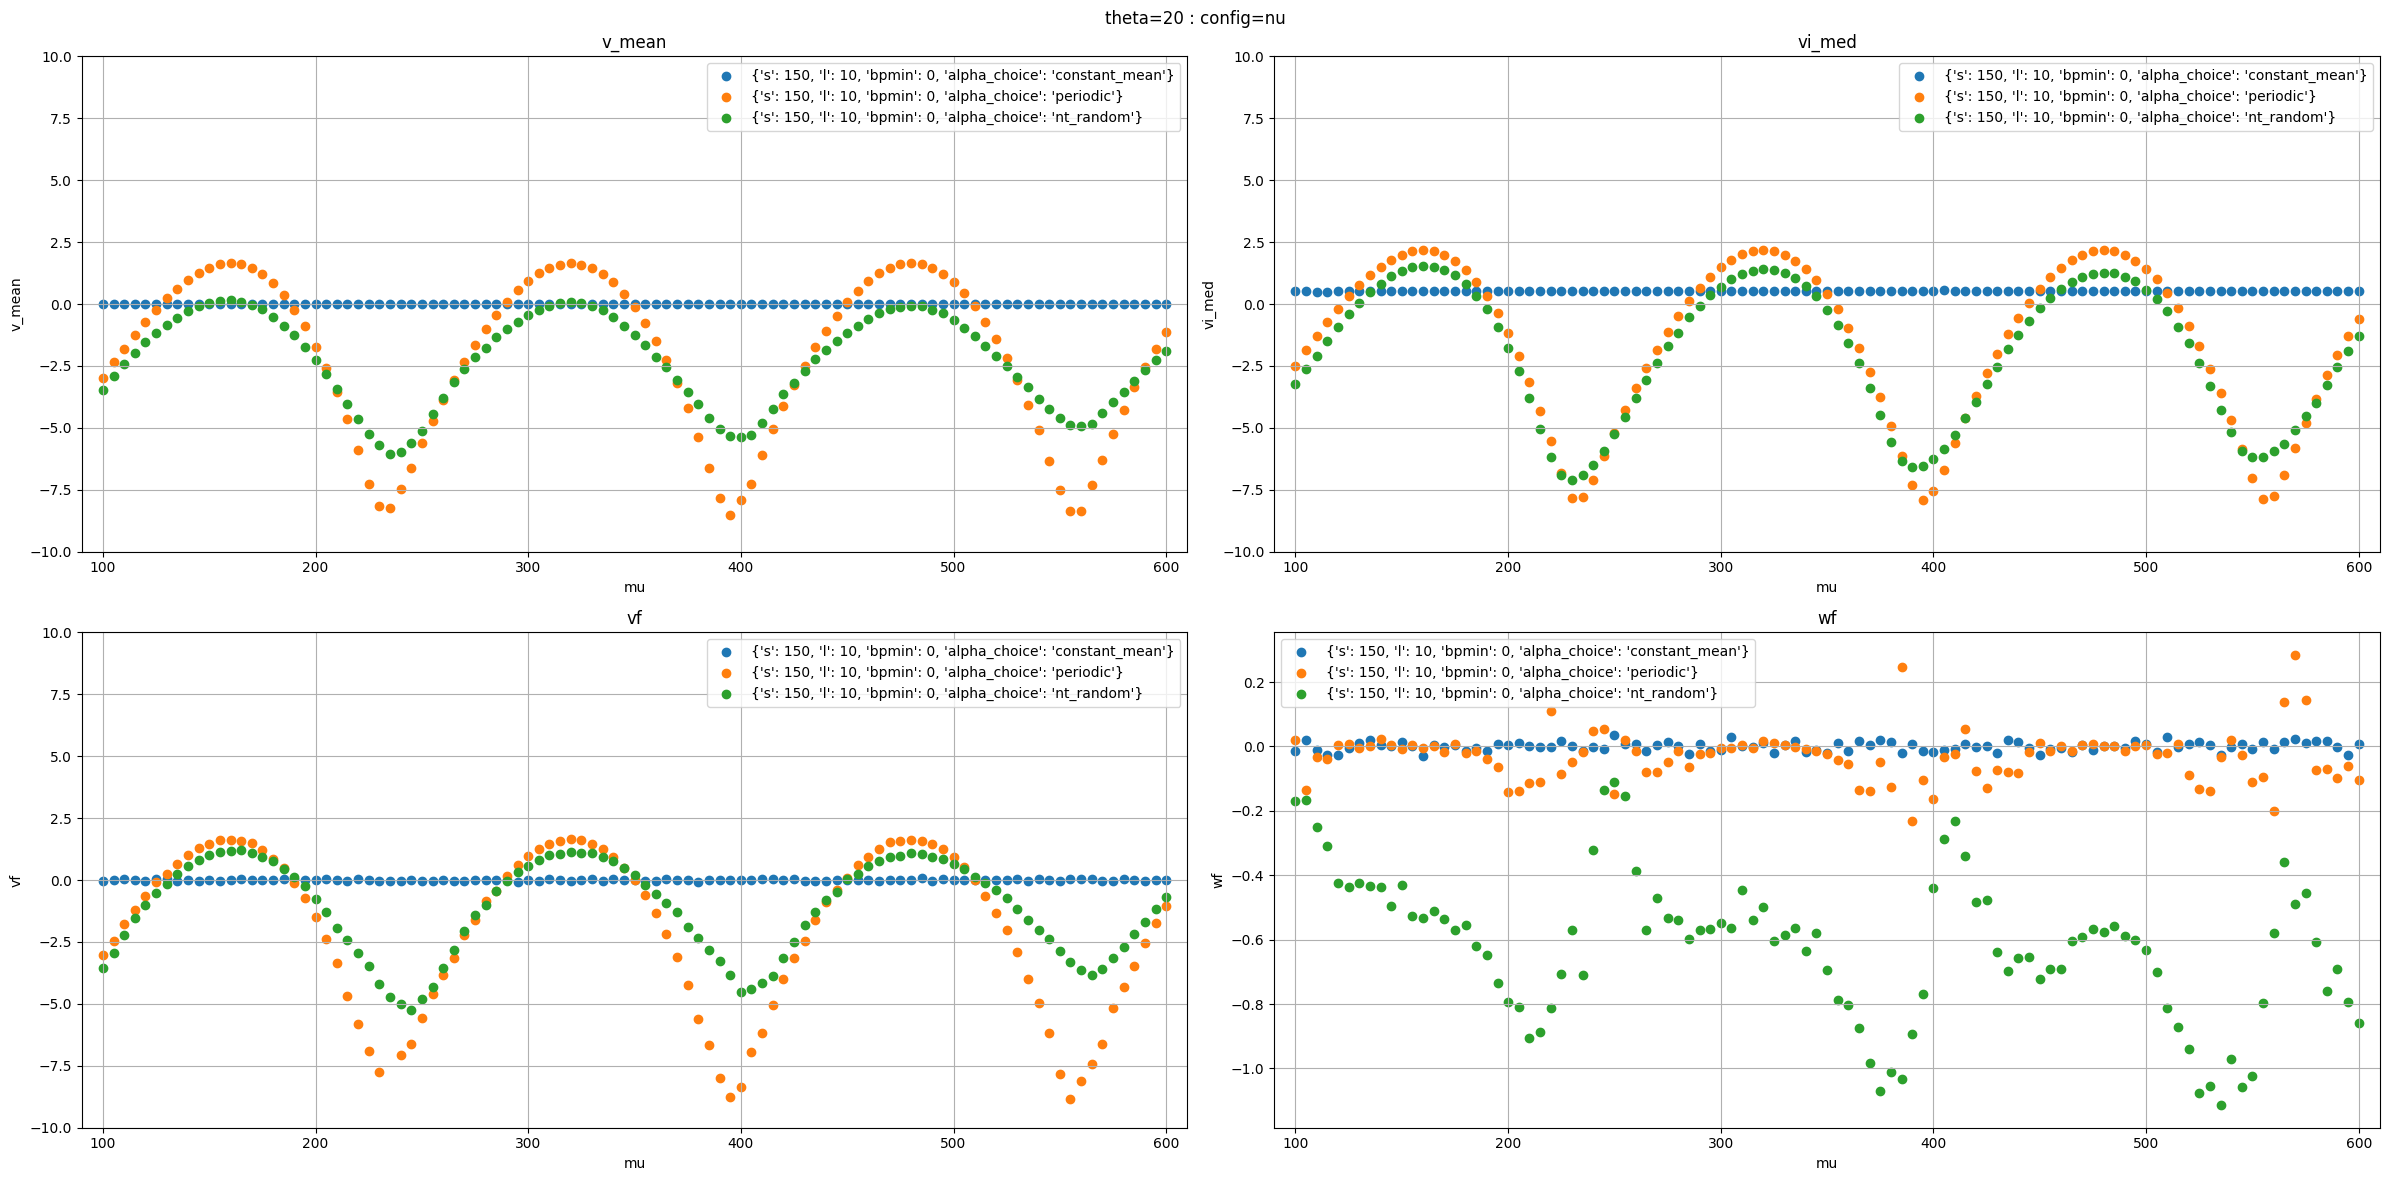

In [66]:
def ncl_multiplot_1D(param: str, param_value: int, config_choice: str):
    """
    Generate a 2x2 multiplot showing different speed-related metrics 
    as a function of the non-fixed parameter, for several configuration sets.

    Args:
        param (str): The name of the fixed parameter. Must be either `'mu'` or `'theta'`.
            This parameter is held constant at `param_value`.
        param_value (int): The fixed value for the `param` parameter.
        config_choice (str): The type of configuration group to use. Must be one of:
            - `'nu'`: selects configurations [0], [1], and [3] from `sorted_combinations_configs`
            - `'ls'`: selects configurations [3:10] plus [2]
            - `'bp'`: selects configurations from index 10 onward

    Raises:
        ValueError: If `param` is not `'mu'` or `'theta'`.
        ValueError: If `config_choice` is not one of `'nu'`, `'ls'`, or `'bp'`.

    Notes:
        - Four metrics are plotted: `"v_mean"`, `"vi_med"`, `"vf"`, and `"wf"`.
        - The x-axis corresponds to the non-fixed parameter (i.e., the one that is not `param`).
        - Each subplot represents one metric, with multiple configurations plotted in each.
        - The `data_1D` function is called to retrieve the (x, y) data for plotting.
        - A global legend and title are added for clarity.

    Example:
        >>> multiplot_1D(param="theta", param_value=25, config_choice="bp")
    """

    # Values to display
    values = ["v_mean", "vi_med", "vf", "wf"]
    n_values = len(values)


    # Fixed parameters
    settings = ["mu", "theta"]
    if param not in settings:
        print('No such param accessible : either mu or theta fixed')
        return None
    if (param == 'mu' and param_value not in np.arange(100,605,5)) or (param == 'theta' and param_value not in np.arange(1, 101, 1)):
        print('Not an accessible value for the parameter : either too low - two high - not binned')
        return None
    nfo = [x for x in settings if x != param][0]

    # Choice of configuration
    if config_choice not in ['nu', 'ls', 'bp']:
        raise ValueError('No such configuration')
    elif config_choice == 'nu':
        config = sorted_combinations_configs[0:2]
        config.append(sorted_combinations_configs[3])
    elif config_choice == 'ls':
        config = sorted_combinations_configs[3:10]
        config.append(sorted_combinations_configs[2])
    elif config_choice == 'bp':
        config = sorted_combinations_configs[10::]


    # Plot initialization
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

    # Loop over each value and config
    for ax, output in zip(axes.flatten(), values):
        for cfg in config:
            mu, v = ncl_data_1D(df=df_pl_main, config=cfg, speed_col=output, fixed_input=param, fixed_value=param_value)
            ax.scatter(mu, v, label=str(cfg), linewidth=1)

        ax.set_title(output)
        ax.set_xlabel(str(nfo))
        ax.set_ylabel(output)
        ax.grid(True, which='both')

        if param == 'theta':
            ax.set_xlim([90,610])
        elif param =='mu':
            ax.set_xlim([-10,110])

        if output in ["v_mean", "vi_med", "vf"]:
            ax.set_ylim([-10, 10])
        ax.legend()


    fig.suptitle(f"{param}={param_value} : config={configuration}")
    plt.tight_layout()
    plt.show()


# Calling function
parameter = 'theta'
parameter_value = 20
configuration = 'nu'
ncl_multiplot_1D(param=parameter, param_value=parameter_value, config_choice=configuration)
# You can call with "config_choice=sorted_combinations_configs" if you want all the results displayed at once

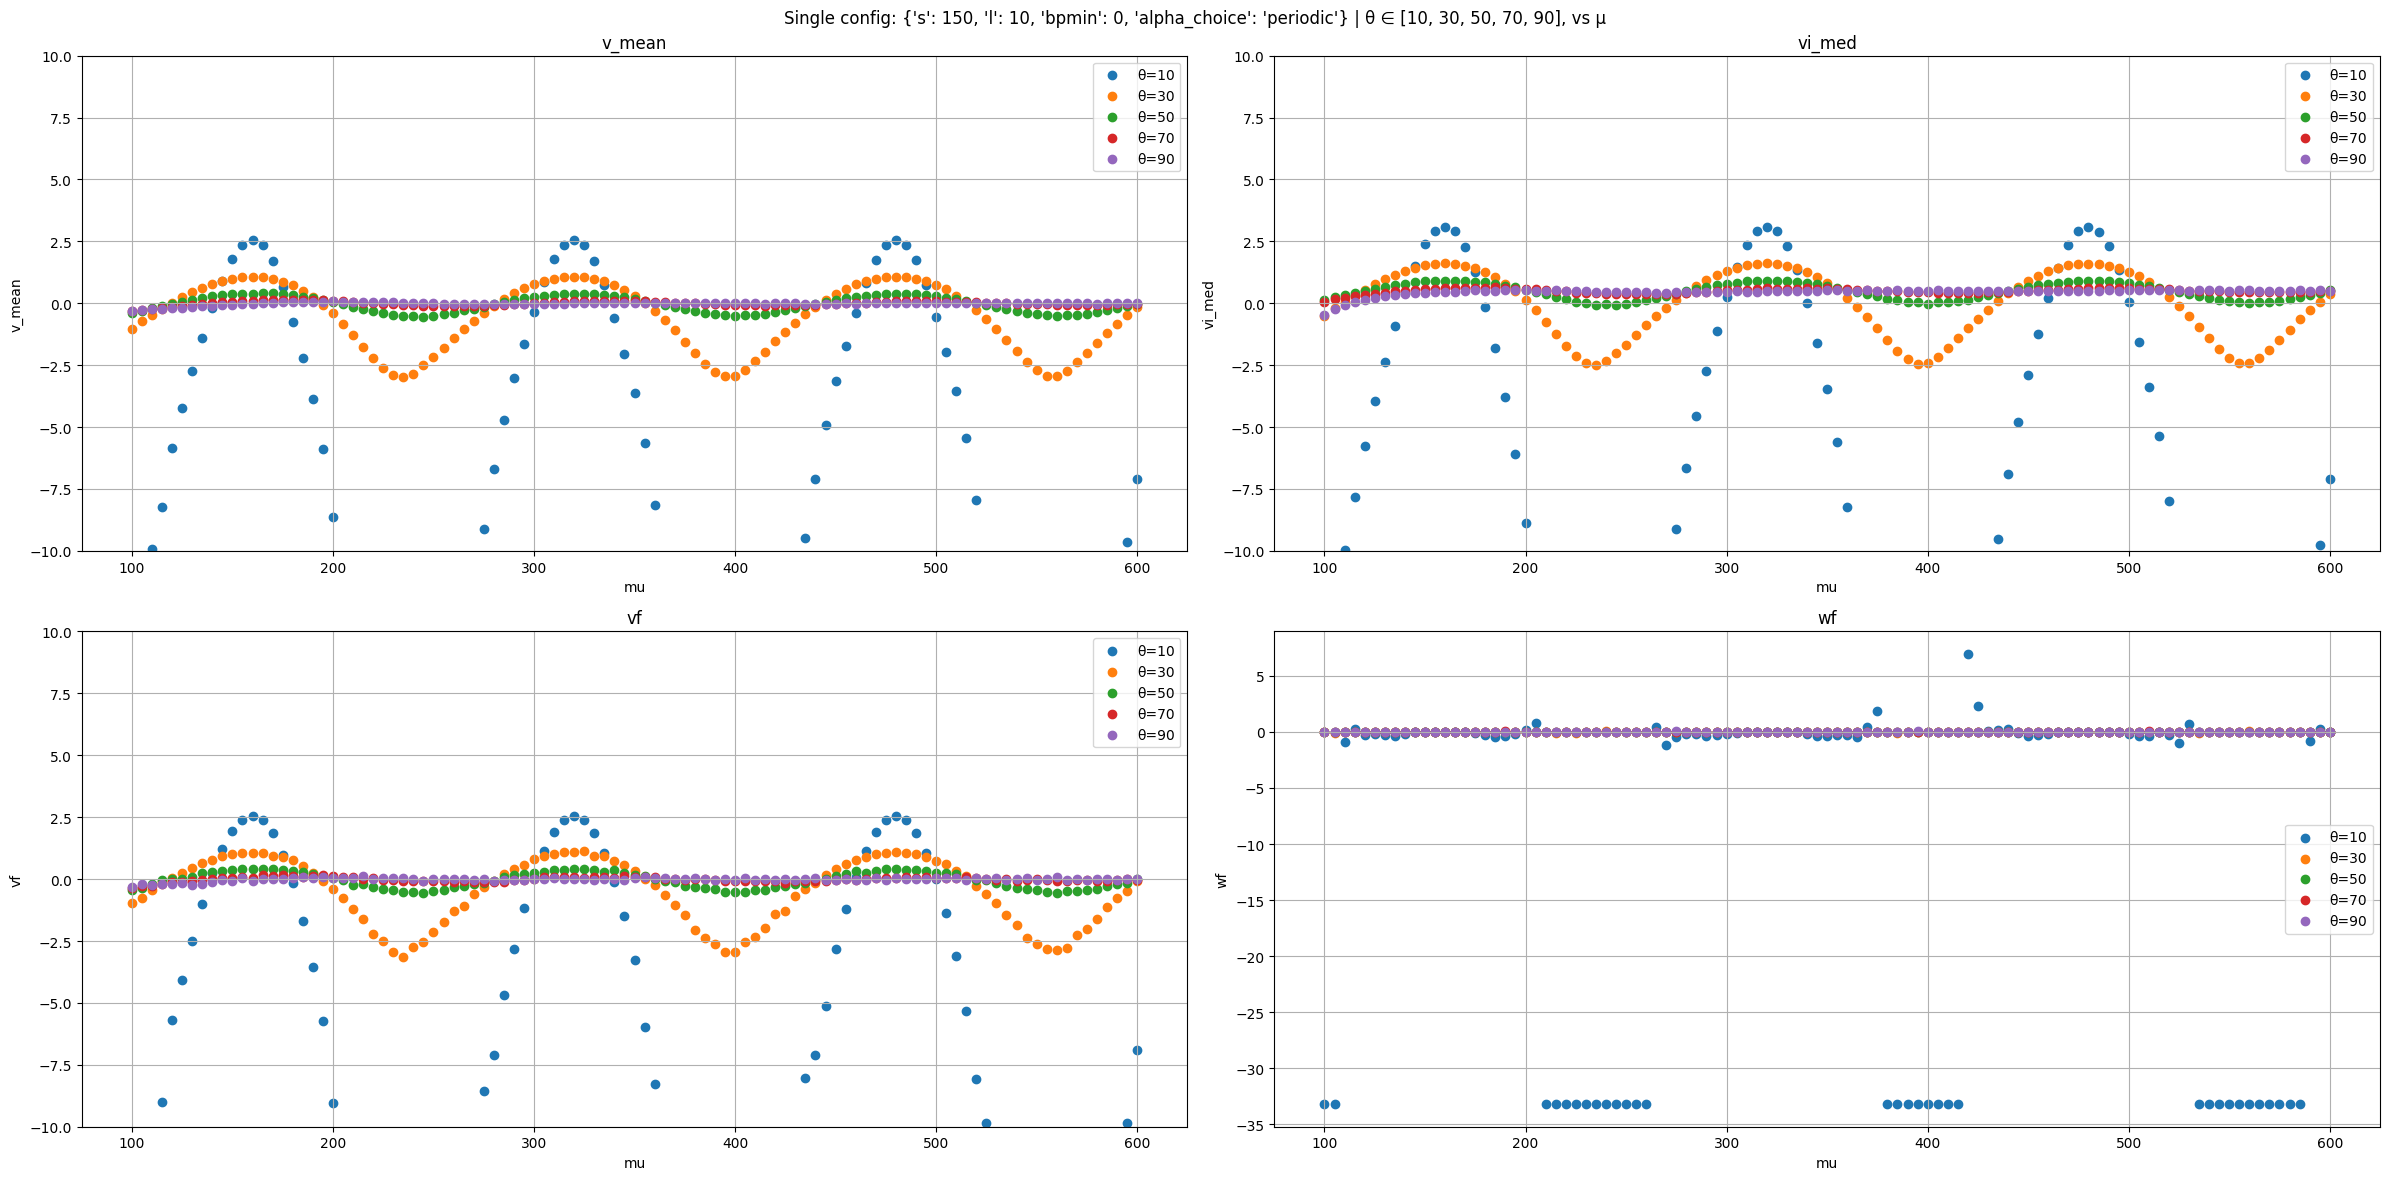

In [65]:
def ncl_multiplot_one_config_few_theta(config: list, theta_values: list = [10, 30, 50, 70, 90]):
    """
    Generate a 2x2 multiplot showing different speed-related metrics as a function of mu,
    for several fixed theta values, using a single configuration.
    """
    import numpy as np
    import matplotlib.pyplot as plt

    metrics = ["v_mean", "vi_med", "vf", "wf"]
    fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(24, 12))

    for ax, metric in zip(axes.flatten(), metrics):
        for theta in theta_values:
            try:
                # This call retrieves all mu for a fixed theta
                mu_vals, y_vals = ncl_data_1D(
                    df=df_pl_main,
                    config=config,
                    speed_col=metric,
                    fixed_input="theta",
                    fixed_value=theta
                )
                if len(mu_vals) == 0 or len(y_vals) == 0:
                    continue
                ax.scatter(x=mu_vals, y=y_vals, label=f"θ={theta}", marker='o')

            except Exception as e:
                print(f"Error at θ={theta} for {metric}: {e}")
                continue
        ax.set_title(metric)
        ax.set_xlabel("mu")
        ax.set_ylabel(metric)
        ax.grid(True, which='both')
        if metric in ["v_mean", "vi_med", "vf"]:
            ax.set_ylim([-10, 10])
        ax.legend()

    fig.suptitle(f"Single config: {config} | θ ∈ {theta_values}, vs μ")
    plt.tight_layout()
    plt.show()



config = sorted_combinations_configs[1]
ncl_multiplot_one_config_few_theta(config=config)


# .